# Supervised

This notebook trains a classification model with all the labeled images from data_augmentation.ipynb

### Imports

In [3]:
import os
import sys
import itertools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers


from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

from tensorflow.keras import regularizers
from itertools import product

### Definitions

In [ ]:
sys.path.insert(0, "../../")
from config import RESULTS_PATH, CROPPED_PATH, MODELS_PATH

# Paths
TRAIN_PATH = os.path.join(CROPPED_PATH, 'ina', 'labeled_images', 'VGG16_kmeans_v0', 'train')
VALIDATION_PATH = os.path.join(CROPPED_PATH, 'ina', 'labeled_images', 'VGG16_kmeans_v0', 'validation')
TEST_PATH = os.path.join(CROPPED_PATH, 'ina', 'labeled_images', 'VGG16_kmeans_v0', 'test')
ENCODER_PATH = os.path.join(MODELS_PATH, 'encoder_SSIM_MAE_Bparams.keras')
RESULT_PATH = os.path.join(RESULTS_PATH, 'resultados_encoder_SSIM+MAE.xlsx')

# Configuration
SHAPE = (128,128,1)
BATCH_SIZE = 32
TRAIN_ENCODER = False
COLOR_MODE="grayscale"
results = []


### Functions

In [14]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)


def plot_conf_matrix(model, generator, titulo='Confusion matrix'):
    ### RETRIVE TEST LABEL FROM GENERATOR ###
    test_num = sum(1 for _ in generator)
    label_test = []
    pred_test = []

    for i, batch in enumerate(generator):
        X, y = batch
        label_test.append(y.numpy())
        predictions = model.predict(X)
        predictions = tf.nn.softmax(predictions, axis=-1)
        pred_test.append(predictions)


    label_test = np.argmax(np.vstack(label_test), axis=1)


    ### COMPUTE PREDICTIONS ON TEST DATA ###
    pred_test = np.argmax(np.vstack(pred_test), axis=1)
    accuracy=accuracy_score(label_test, pred_test)
    recall=recall_score(label_test, pred_test,pos_label=0)
    specificity=recall_score(label_test, pred_test,pos_label=1)
    precision = precision_score(label_test, pred_test, pos_label=0)
    # pred_test = pred_test[:label_test.shape[0],]
    ### ACCURACY ON TEST DATA ###
    print("-" * 40)
    print('ACCURACY:', accuracy)
    print('RECALL:',recall)
    print('PRECISION:', precision)
    print('SPECIFICITY:',specificity)
    print("-" * 40)
    print("\n")
    ### CONFUSION MATRIX ON TEST DATA ###
    cnf_matrix = confusion_matrix(label_test, pred_test)
    results.append({'Model': titulo, 'Accuracy': accuracy , 'Recall':recall,'Precision':precision,'Specificity':specificity})

    plt.figure(figsize=(7,7))
    plot_confusion_matrix(cnf_matrix, classes=['cell', 'not'], title=titulo)
    plt.title(titulo)
    plt.show()


def get_model(pretrain_encoder,TRAIN_ENCODER,input_shape,dropout_rate, l2_reg):
    encoder=pretrain_encoder

    inp = keras.Input(shape=input_shape)
    x = inp

    encoder.trainable = TRAIN_ENCODER

    x = encoder(x)

    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    out =layers.Dense(2, activation='linear')(x)


    model = keras.Model(inp, out)

    return model

### Load datasets

In [16]:
# data generator function
def data_gen ():
    train_generator = tf.keras.utils.image_dataset_from_directory(
        TRAIN_PATH,
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    train_generator = train_generator.map(
        lambda x, y: (x/255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_generator = train_generator.prefetch(buffer_size=tf.data.AUTOTUNE)


    validation_generator = tf.keras.utils.image_dataset_from_directory(
        VALIDATION_PATH,
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    validation_generator = validation_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    validation_generator = validation_generator.prefetch(buffer_size=tf.data.AUTOTUNE)



    test_generator = tf.keras.utils.image_dataset_from_directory(
        TEST_PATH,
        labels="inferred",
        label_mode="categorical",
        batch_size=BATCH_SIZE,
        image_size=(SHAPE[0], SHAPE[1]),
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=42
    )
    test_generator = test_generator.map(
        lambda x, y: (x / 255.0, y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    test_generator = test_generator.prefetch(buffer_size=tf.data.AUTOTUNE)


    return train_generator,validation_generator,test_generator


Found 14277 files belonging to 2 classes.
(32, 128, 128, 1)
(32, 2)


I0000 00:00:1746146439.148217  322628 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1102 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


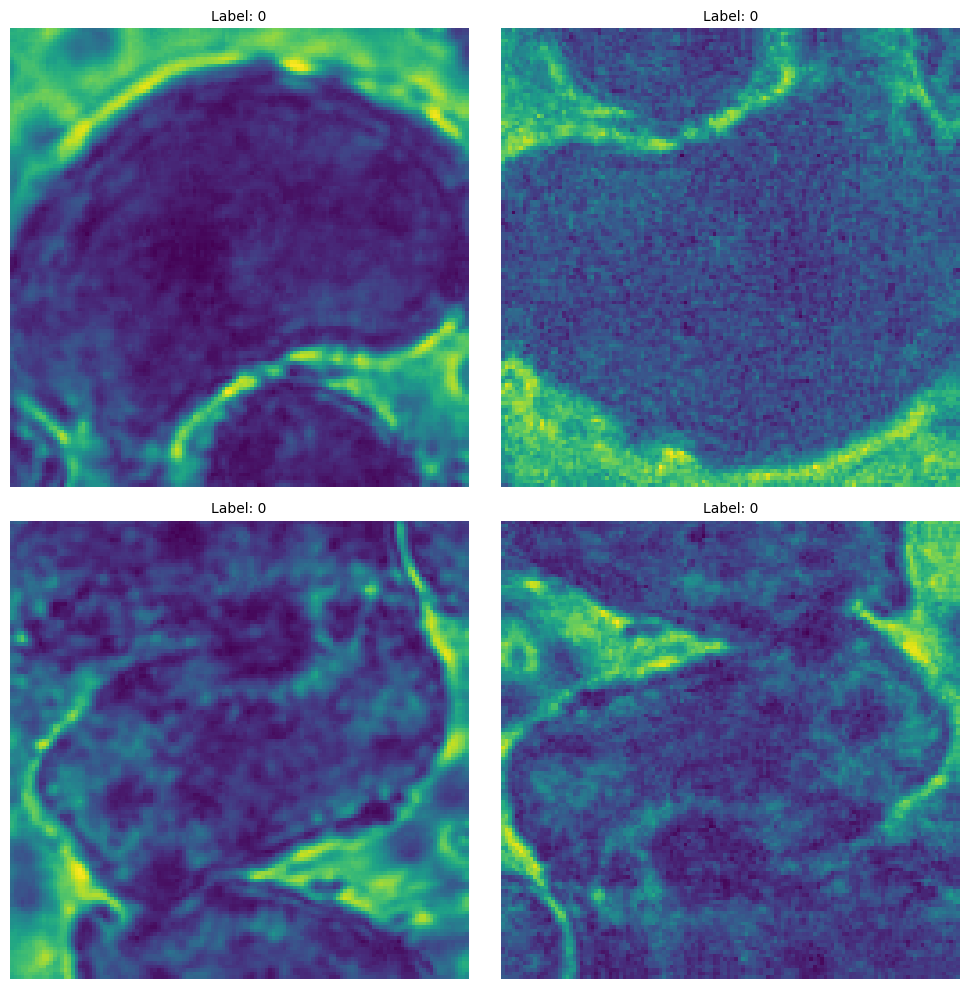

In [11]:
# plot images
train_generator = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(SHAPE[0], SHAPE[1]),
    color_mode=COLOR_MODE,
    shuffle=False,
)



for images, labels in train_generator:
    print(images.shape)
    print(labels.shape)

    #filenames_in_batch = [train_generator.filenames[idx] for idx in train_generator.index_array]

    plt.figure(figsize=(10, 10))

    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))

        #file_name = filenames_in_batch[i]
        label = np.argmax(labels[i])
        plt.title(f"Label: {label}", fontsize=10)

        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [12]:
train_generator.class_names

['cells', 'not']

### Train model

In [ ]:
train_generator,validation_generator,test_generator=data_gen()
stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2,
)

param_grid = {
    'dropout_rate': [0.3, 0.5],
    'l2_reg': [1e-3, 0.01],
}
combinations = list(product(*param_grid.values()))
combinations.append((0.0, 0.0))

for i, params in enumerate(combinations):

  encoder_name="Encoder_SSIM+MAE"+str(i)
  encoder= keras.saving.load_model(ENCODER_PATH)
  model = get_model(encoder,TRAIN_ENCODER,SHAPE,params[0],params[1])
  model.compile(keras.optimizers.Adam(
    #  1e-4
      ),
      loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
      )


  model.fit(train_generator,
          epochs=50,
          validation_data = validation_generator,
          callbacks=[ stopping],
          )
  
  model.save(os.path.join(MODELS_PATH, 'supervised_{encoder_name}.keras'))
  print()
  print(params)
  print()
  plot_conf_matrix(model, validation_generator, f'{encoder_name} - Validation')
  plot_conf_matrix(model, test_generator, f'{encoder_name} - Test')



Found 14277 files belonging to 2 classes.
Found 7000 files belonging to 2 classes.
Found 1999 files belonging to 2 classes.
Epoch 1/50


I0000 00:00:1746146599.908912  329107 service.cc:152] XLA service 0x7945ac015d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746146599.908925  329107 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-05-01 21:43:19.941632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746146600.118069  329107 cuda_dnn.cc:529] Loaded cuDNN version 90701


 98/447 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5548 - loss: 0.8129

I0000 00:00:1746146601.408447  329107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6054 - loss: 0.7265 - val_accuracy: 0.8719 - val_loss: 0.4599
Epoch 2/50
447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7033 - loss: 0.5902 - val_accuracy: 0.8764 - val_loss: 0.3934
Epoch 3/50
268/447 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7462 - loss: 0.5336

KeyboardInterrupt: 

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results)

results_df.to_excel(RESULT_PATH)

print(results_df)


                            Model  Accuracy    Recall  Precision  Specificity
0  Encoder_SSIM+MAE0 - Validation  0.768265  0.802380   0.735784     0.737143
1        Encoder_SSIM+MAE0 - Test  0.957500  0.947000   0.967314     0.968000
2  Encoder_SSIM+MAE1 - Validation  0.764530  0.798309   0.732261     0.733714
3        Encoder_SSIM+MAE1 - Test  0.946500  0.929000   0.962694     0.964000
4  Encoder_SSIM+MAE2 - Validation  0.751681  0.757908   0.731339     0.746000
5        Encoder_SSIM+MAE2 - Test  0.909000  0.856000   0.957494     0.962000
6  Encoder_SSIM+MAE3 - Validation  0.760496  0.772941   0.737597     0.749143
7        Encoder_SSIM+MAE3 - Test  0.934000  0.900000   0.965665     0.968000
8  Encoder_SSIM+MAE4 - Validation  0.781712  0.795803   0.758507     0.768857
9        Encoder_SSIM+MAE4 - Test  0.945000  0.925000   0.963542     0.965000
